# Task 1: Retrieving and Preparing the Data

In [1]:
import datetime as dt

# Importing packages - Pandas, Numpy, Seaborn, Scipy
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, sys
import matplotlib.style as style; style.use('fivethirtyeight')
from scipy.stats import zscore, norm

np.random.seed(0)

# Modelling - LR, KNN, NB, Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Oversampling
# from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')
pd.options.display.max_rows = 4000

In [2]:
# Reading the data as dataframe
file_path = "./online_retail_II.xlsx"
df = pd.read_excel(file_path)

## Attribute Information

* **`Invoice`**: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
* **`StockCode`**: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
* **`Description`** : Product (item) name. Nominal.
* **`Quantity`**: The quantities of each product (item) per transaction. Numeric.
* **`InvoiceDate`**: Invice date and time. Numeric. The day and time when a transaction was generated.
* **`Price`**: Unit price. Numeric. Product price per unit in sterling (£).
* **`Customer ID`**: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
* **`Country`**: Country name. Nominal. The name of the country where a customer resides.

## Data Shape

In [3]:
# Print info of the dataframe columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [4]:
# Print out dataset's shape and the total number of missing values
print("Dataset has" , df.shape[0], "rows  and" , df.shape[1], "columns. There are ", df.isna().any().sum(), "columns with missing values")

Dataset has 525461 rows  and 8 columns. There are  2 columns with missing values


## Data Cleaning
### Dropping duplicated values

In [5]:
# Count total number of duplicated rows
df.duplicated().sum()

6865

In [6]:
# Drop all duplicated rows
df.drop_duplicates(inplace=True)
# Count total number of duplicated rows
df.duplicated().sum()

0

### Dealing with Missing values

In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107833
Country             0
dtype: int64

In specific, the **Description** column has 2928 missing values while **CustomerID** column has 107927 null values. To handle these missing values, let's look at a more comprehensive column analysis.

#### Exploratory Data Analysis
**Invoice:**

Three types of invoices:
- Start with Number: Normal transaction
- Start with Letter A: Represent a bad debt adjustment and are unrelated to any Customer ID.
- Start with Letter C: Represent transactions that were canceled. Although not always, this seems to be connected to negative Quantity values.

In [8]:
# Invoice records beginning with 'A'
df[df['Invoice'].str.contains('A', na = False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [9]:
# Invoice records beginning with 'C'
df[df["Invoice"].str.contains("C", na=False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


**StockCode & Description**
- StockCode contains 5-7 character strings mostly numbers
- Given that the same description could be written in various case variations, let us just make all descriptions lowercase and remove punctuations. 
- Some unique StockCodes are M, B, TEST001, D
Each product's item distinguished by **StockCode** has a product description. However, with the same StockCode, the description is sometimes left blank due to error data entry. 

In [10]:
# Example of same stockcode but blank description
df[df['StockCode']==20683]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.00,NaN,United Kingdom
24774,491435,20683,RAIN GIRL CHILDS UMBRELLA,1,2009-12-11 10:10:00,3.25,14606.0,United Kingdom
43854,493252,20683,NaN,1,2009-12-22 13:51:00,0.00,NaN,United Kingdom


In [11]:
# Check total number of unique values in Description col
print("Number of unique descriptions:",df['Description'].nunique())

Number of unique descriptions: 4681


In [12]:
# Change the description text to lowercase
df['Description'] = df['Description'].str.lower()
# Replace the description text to match the pattern
df['Description'] = df['Description'].replace(to_replace=r'[^\w\s]', value='', regex=True) 

In [13]:
print("Number of unique description:",df['Description'].nunique())

Number of unique description: 4619


In [14]:
# Check null values in Description column
df[df["Description"].isnull() == True].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom
4296,489806,18010,NaN,-770,2009-12-02 12:42:00,0.0,NaN,United Kingdom


About 20 values are dropped after handling some unmatched patterns in the text. We can see from the aforementioned record that every null description has a zero price and a null customer ID. 

**Quantity:**

- The quantity column not only displays the quantity of items purchased, but it also displays the amount of cancelled/returned items by encoding the cancelled transactions as negative. Each of these cancelled transactions is associated with the Invoice Number. However, there is only 1 instance whose invoice starts with C but the Quantity is positive (1).


In [15]:
print('Number of invoices for cancelation that also have negative quantity',
      df.loc[(df['Invoice'].str.contains('C', na = False)) & (df['Quantity'] < 0)].shape[0])

Number of invoices for cancelation that also have negative quantity 10181


In [16]:
print('The number of entries with negative quantity', df[(df['Quantity'] < 0)].shape[0])

The number of entries with negative quantity 12302


In [17]:
print('Number of invoices for cancelation that also have negative quantity',
      df.loc[(df['Invoice'].str.contains('C', na = False)) & (df['Quantity'] < 0)].shape[0])

Number of invoices for cancelation that also have negative quantity 10181


In [18]:
df.loc[(df['Invoice'].str.contains('C', na = False)) & (df['Quantity'] < 0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,paper bunting white lace,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,cream felt easter egg basket,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,potting shed sow n grow set,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,potting shed twine,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,paper chain kit retro spot,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 foil heart cake cases,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,roses regency teacup and saucer,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,regency cakestand 3 tier,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


In [19]:
df.loc[(df['Invoice'].str.contains('C', na = False)) & (df['Quantity'] >= 0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
76799,C496350,M,manual,1,2010-02-01 08:24:00,373.57,NaN,United Kingdom


In [20]:
negative_quantities = df[df['Quantity'] < 0]
negative_quantities

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,paper bunting white lace,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,cream felt easter egg basket,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,potting shed sow n grow set,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,potting shed twine,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,paper chain kit retro spot,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525234,538161,46000S,dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom
525235,538162,46000M,dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


In [21]:
# Dropping negative quantities
df.drop(negative_quantities.index, inplace=True)

**InvoiceDate**

In [22]:
max_invoice_date = df['InvoiceDate'].max()
min_invoice_date = df['InvoiceDate'].min()
date_fmt = '%Y-%m-%d'
print('The data ranges from {} to {}'.format(min_invoice_date.strftime(date_fmt), 
                                             max_invoice_date.strftime(date_fmt) ))

The data ranges from 2009-12-01 to 2010-12-09


**Price**

In [23]:
df['Price'].describe()

count    506294.000000
mean          3.991786
std         128.813982
min      -53594.360000
25%           1.250000
50%           2.100000
75%           4.210000
max       25111.090000
Name: Price, dtype: float64

- The maximum and minimum values could be considered to be outliers since the mean value is only **4.742955**.<br>
- The column also contains negative values.


In [24]:
# Check for rows with negative values
negative_prices = df[df['Price'] < 0]
negative_prices

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


In [25]:
# Dropping negative prices
df.drop(negative_prices.index, inplace=True)

- The **Description** column of the above rows suggests that these rows might not contain the data of real transactions. These could be made-up data which were produced to serve the purpose of dealing the bad debts.
- Based on the above hypothesis, dropping these rows could be reasonable.

**Customer ID**

In [26]:
df['Customer ID'].describe()

count    400947.000000
mean      15361.454639
std        1680.669487
min       12346.000000
25%       13985.000000
50%       15311.000000
75%       16805.000000
max       18287.000000
Name: Customer ID, dtype: float64

In [27]:
# Dropping unknown customerID
df.dropna(subset=['Customer ID'],how='all',inplace=True)

**Country**

In [28]:
df['Country'].describe()

count             400947
unique                37
top       United Kingdom
freq              364255
Name: Country, dtype: object

In [29]:
df['Country'].value_counts()

United Kingdom          364255
EIRE                      8503
Germany                   7652
France                    5452
Netherlands               2729
Spain                     1228
Switzerland               1170
Belgium                   1037
Portugal                   983
Sweden                     867
Channel Islands            821
Italy                      708
Australia                  630
Cyprus                     533
Austria                    524
Greece                     512
Denmark                    418
Norway                     365
Finland                    347
United Arab Emirates       315
Unspecified                277
USA                        230
Poland                     182
Malta                      170
Japan                      164
Lithuania                  154
Singapore                  117
Canada                      77
Thailand                    76
Israel                      74
Iceland                     71
RSA                         65
Brazil  

In [30]:
# Check for space characters
df['Country'].str.isspace().sum()

0

- **Country** column contains names of 40 different countries without typos or duplicates or containing any space.
- **United Kingdom** appears to be the most frequent value to show up.

#### Detecting Outliers

In [31]:
# Dataframe description
df.describe()

,Quantity,Price,Customer ID
count,400947.000000,400947.000000,400947.000000
mean,13.768523,3.305571,15361.454639
std,97.639816,35.046376,1680.669487
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13985.000000
50%,5.000000,1.950000,15311.000000
75%,12.000000,3.750000,16805.000000
max,19152.000000,10953.500000,18287.000000


Due to the significant difference between the mean and maximum values in both numerical columns, we can clearly see that the dataset contains outliers (quantity and price). It is better visualized in the graph below. 

<AxesSubplot:>

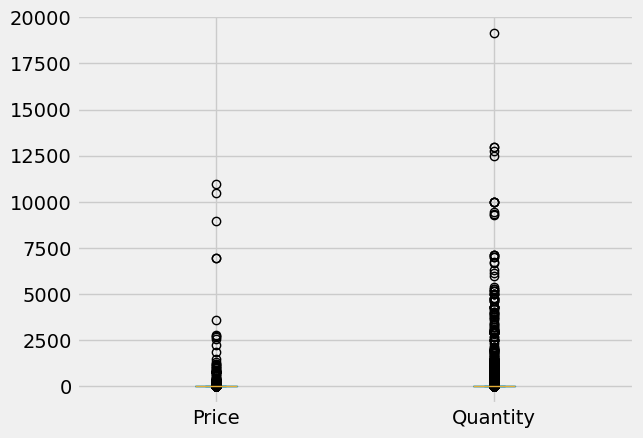

In [32]:
# Boxplot graph for Price and Quantity column
df[["Price","Quantity"]].plot(kind="box")

In [33]:
df[df['Quantity']>10000]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
90857,497946,37410,black and white paisley flower mug,19152,2010-02-15 11:57:00,0.1,13902.0,Denmark
127166,501534,21099,set6 strawberry paper cups,12960,2010-03-17 13:09:00,0.1,13902.0,Denmark
127167,501534,21092,set6 strawberry paper plates,12480,2010-03-17 13:09:00,0.1,13902.0,Denmark
127168,501534,21091,set6 woodland paper plates,12960,2010-03-17 13:09:00,0.1,13902.0,Denmark
127169,501534,21085,set6 woodland paper cups,12744,2010-03-17 13:09:00,0.1,13902.0,Denmark


In [34]:
df[df['Price']>5000]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
74356,496115,M,manual,1,2010-01-29 11:04:00,8985.60,17949.0,United Kingdom
129903,501766,M,manual,1,2010-03-19 11:35:00,6958.17,15760.0,Norway
129987,501768,M,manual,1,2010-03-19 11:45:00,6958.17,15760.0,Norway
135013,502263,M,manual,1,2010-03-23 15:22:00,10953.50,12918.0,United Kingdom
358639,524159,M,manual,1,2010-09-27 16:12:00,10468.80,14063.0,United Kingdom


- The same person, with Customer ID 13902, transacts all transactions with a quantity over 10,000 and an item price of 0.01. Given the quantity of merchandise sold, we can assume that this buyer is a business owner who operates a retail store in Denmark. These outliers are reasonable that is it better not to be modified.
- With regard to *Price* outliers, as the products are manually made, which results in higher prices.

# Task 2: Feature Engineering

## Add new columns

In [35]:
# # Add new column: OrderCancelled
# def map_order_cancelled(row):
#     return 0 if "C" not in str(row).upper() else 1

# df["OrderCancelled"] = df["Invoice"].map(map_order_cancelled)
# removed due to heavily skewed class

In [36]:
def map_international_shipping(row):
    return 0 if row == "United Kingdom" else 1
df['International Shipping']= df['Country'].map(map_international_shipping)
df['International Shipping'].value_counts()

0    364255
1     36692
Name: International Shipping, dtype: int64

In [37]:
# Add new column: TotalPrice
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [38]:
# Add date related columns
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Date']=df['InvoiceDate'].dt.date

df["Week Day"] = df["InvoiceDate"].dt.weekday
df['Day']=df['InvoiceDate'].dt.day
df['Month']=df['InvoiceDate'].dt.month
df["Quarter"] = df["InvoiceDate"].dt.quarter
df["Year"] = df["InvoiceDate"].dt.year
df['Time'] = df['InvoiceDate'].dt.time

def map_is_weekend(row):
    return 1 if row == 5 or row == 6 else 0
df['isWeekend'] = df['Week Day'].map(map_is_weekend)

In [39]:
df['Qdate'] = df['InvoiceDate'].dt.to_period("Q").dt.end_time
df['Qdate'].unique()
quarters = df['Qdate'].unique()

In [40]:
quarters_df_list = []

for index, quarter in enumerate(quarters):
    if (index == len(quarters) - 1):
        break;
    
    feature_df = df[df['Qdate'] == quarters[index]]
    label_df = df[df['Qdate'] == quarters[index + 1]]
    
    df_international = feature_df[feature_df["International Shipping"] == 1]
    df_international = df_international.groupby("Customer ID")["Invoice"].nunique().reset_index();
    df_international.columns = ["Customer ID", "International Shipping"]
    df_international = df_international.set_index("Customer ID");
    
    quarter_df = feature_df.groupby("Customer ID").agg({
        "TotalPrice" : ["sum", "mean", "min"],
        "Quantity": ["sum", "mean", "min", "max", "count"],
        "Price": ["mean", "min", "max"],
        "isWeekend": ["sum", "count"]
        # add more features
    })
    
    
    quarter_df = quarter_df.join(df_international)
    quarter_df = quarter_df.fillna(0)
    
    label_df = label_df.groupby("Customer ID").agg({
        "Invoice": "count"
    })

    label_df["target"] = (label_df["Invoice"] > 0).astype(int)
    label_df = label_df.drop(columns = ["Invoice"])
    
    
    final_df = quarter_df.join(label_df)
    final_df["target"] = final_df["target"].fillna(0)
    quarters_df_list.append(final_df)

final_df = pd.concat(quarters_df_list)

# Task 3: Data Modelling
## Classification Approach

In [41]:
X = final_df.drop(['target'], axis = 1)
y = final_df['target']

display(X.describe().T, X.shape, y.shape);

,count,mean,std,min,25%,50%,75%,max
"(TotalPrice, sum)",6867.0,915.684483,3071.676184,0.0,230.185000,401.370000,811.655000,99125.700000
"(TotalPrice, mean)",6867.0,39.599632,201.802983,0.0,12.304094,17.742222,27.623427,10953.500000
"(TotalPrice, min)",6867.0,19.519932,178.785942,0.0,1.260000,6.600000,10.200000,10953.500000
"(Quantity, sum)",6867.0,598.987476,3592.582975,1.0,110.000000,232.000000,468.000000,220506.000000
"(Quantity, mean)",6867.0,24.984583,136.347650,1.0,5.447222,9.541667,15.263693,4866.777778
"(Quantity, min)",6867.0,9.939420,90.140854,1.0,1.000000,1.000000,3.000000,4008.000000
"(Quantity, max)",6867.0,74.169361,343.216777,1.0,20.000000,30.000000,50.000000,19152.000000
"(Quantity, count)",6867.0,40.647736,65.069929,1.0,13.000000,24.000000,48.000000,1395.000000
"(Price, mean)",6867.0,8.291558,178.337684,0.0,2.229972,2.960606,3.922511,10953.500000
"(Price, min)",6867.0,4.664130,161.059048,0.0,0.290000,0.420000,0.850000,10953.500000


(6867, 14)

(6867,)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42);
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape);

(4806, 14)

(2061, 14)

(4806,)

(2061,)

In [43]:
def train_and_plot(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
    print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))

    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', auc.round(3))

    # ROC Curve
    model_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure(figsize = (12.8 , 6))
    plt.plot(fpr, tpr, label = 'AUC = {})'.\
             format(model_roc_auc.round(4)))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = 'lower right')
    plt.show()
    
    return model

### Model 1: Logistic Regression

Model accuracy for train set: 0.621
Model accuracy for test set: 0.631

              precision    recall  f1-score   support

         0.0       0.66      0.12      0.20       808
         1.0       0.63      0.96      0.76      1253

    accuracy                           0.63      2061
   macro avg       0.65      0.54      0.48      2061
weighted avg       0.64      0.63      0.54      2061


Confusion Matrix:
 [[  97  711]
 [  49 1204]]

Accuracy Score:  0.631


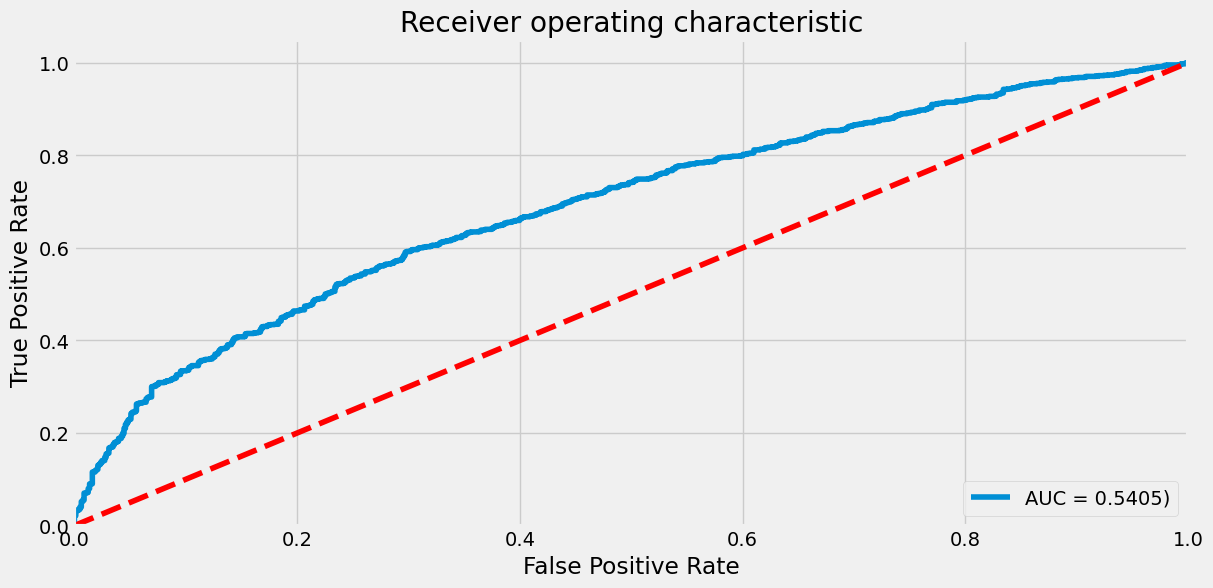

In [44]:
LR = LogisticRegression()
LR_model = train_and_plot(LR, X_train, y_train, X_test, y_test)

### Model 2: Decision Tree

Model accuracy for train set: 0.769
Model accuracy for test set: 0.626

              precision    recall  f1-score   support

         0.0       0.53      0.42      0.47       808
         1.0       0.67      0.76      0.71      1253

    accuracy                           0.63      2061
   macro avg       0.60      0.59      0.59      2061
weighted avg       0.61      0.63      0.62      2061


Confusion Matrix:
 [[336 472]
 [299 954]]

Accuracy Score:  0.626


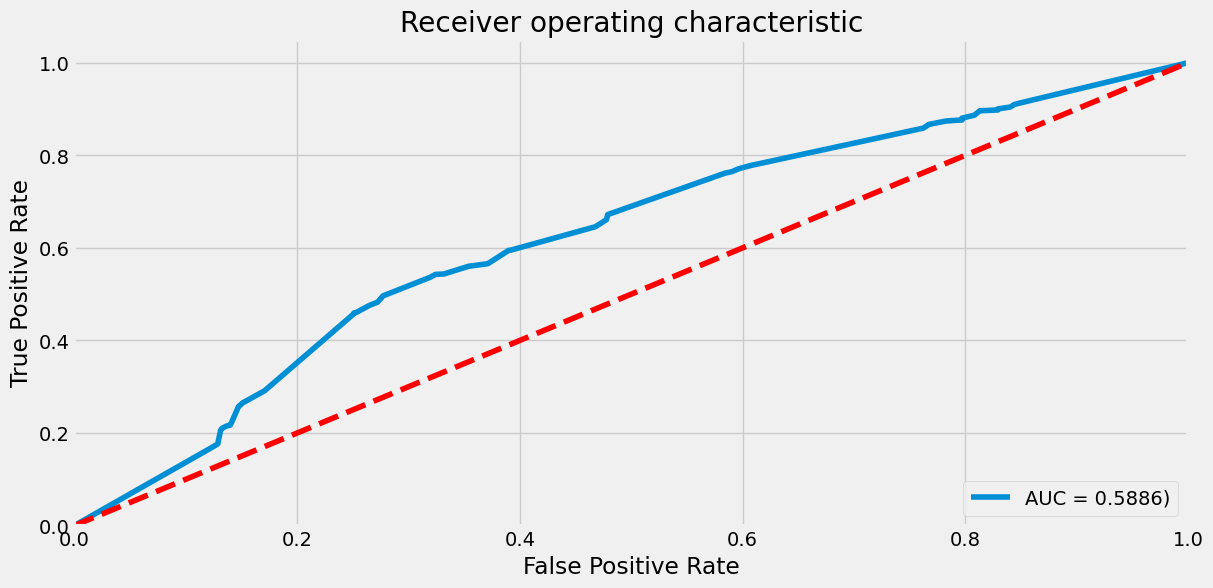

In [45]:
DTC = DecisionTreeClassifier(max_depth=11)
DTC_model = train_and_plot(DTC, X_train, y_train, X_test, y_test)

### Model 3: K-Neighbors Classifier Approach

Model accuracy for train set: 0.742
Model accuracy for test set: 0.623

              precision    recall  f1-score   support

         0.0       0.52      0.45      0.48       808
         1.0       0.67      0.73      0.70      1253

    accuracy                           0.62      2061
   macro avg       0.60      0.59      0.59      2061
weighted avg       0.62      0.62      0.62      2061


Confusion Matrix:
 [[365 443]
 [333 920]]

Accuracy Score:  0.623


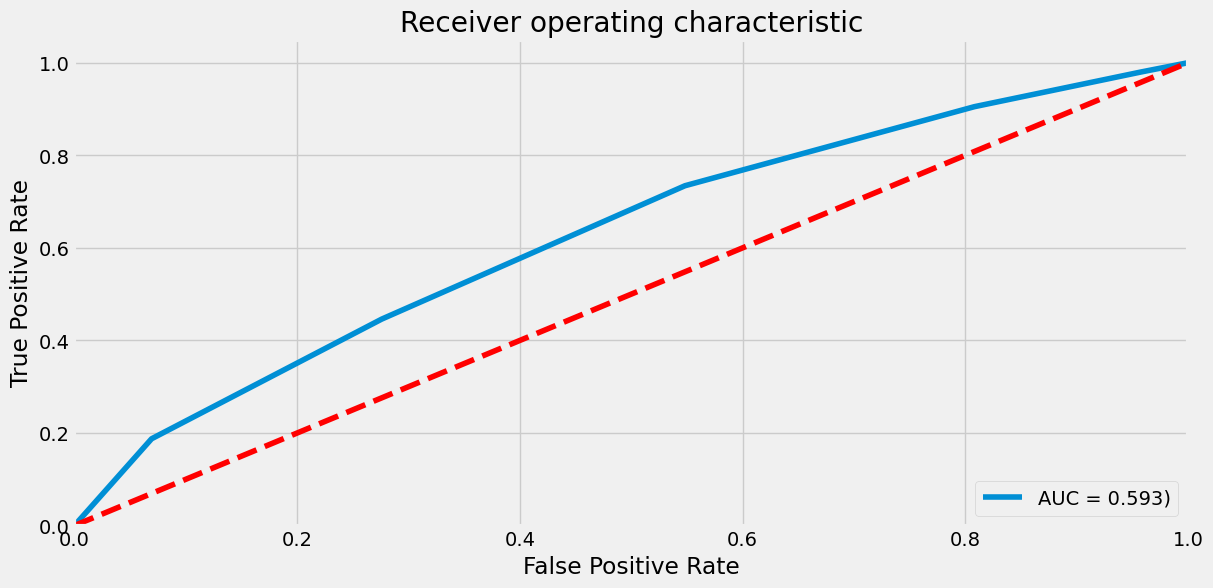

In [46]:
KNN = KNeighborsClassifier()
KNN_model = train_and_plot(KNN, X_train, y_train, X_test, y_test)

## Clustering Approach
### RFM Analysis
One of the most important models used by businesses to develop marketing and advertising strategies is the RFM (Recency, Frequency, and Monetary) analytical design. The three variables (attributes) below make up the RFM design, which represents consumer consumption patterns based on transaction databases:
- Recency: Number of days since last purchase. The likelihood that a customer will make another purchase increases as the date approaches.
- Frequency: Number of tracsactions take place at one time. It is anticipated that as customer loyalty increases, purchase frequency increases and consumer value increases as well.
- Monetary: Total amount of transactions. The greater the monetary value, the greater the buyer's profit contributions to the company as well as the greater the consumer value.

With the help of RFM segmentation, marketers can communicate with specific groups of customers in a way that is much more appropriate for their particular behavior and thus produce much higher response rates, as well as greater customer loyalty and lifetime value. RFM segmentation is a highly effective tool for identifying customer groups that should receive special treatment, just like other segmentation techniques. 

### Recency

In [47]:
# Create a new user datadrame
user = pd.DataFrame(df['Customer ID'].unique())
user.columns = ['Customer ID']


In [48]:
# Get the latest purchases from customers from the dataset
max_purchase = pd.DataFrame(df.groupby('Customer ID')['InvoiceDate'].max().reset_index())

# Rename the column 'InvoiceDate' to 'max purchase date'
max_purchase.columns= ['Customer ID','max_purchase_date']

# Use the observation point's maximum invoice date in the dataset to calculate the recency.
max_purchase['Recency'] = (max_purchase['max_purchase_date'].max() - max_purchase['max_purchase_date']).dt.days

# Sort by recency
max_purchase.sort_values(by='Recency',ascending=False).head()

,Customer ID,max_purchase_date,Recency
3184,16763.0,2009-12-01 15:26:00,373
179,12636.0,2009-12-01 09:55:00,373
3398,17056.0,2009-12-01 12:55:00,373
14,12362.0,2009-12-01 10:10:00,373
809,13526.0,2009-12-01 13:13:00,373


In [49]:
# Combine the regency column with the user dataframe
user = pd.merge(user,max_purchase[['Customer ID','Recency']],on='Customer ID')
user.head()

,Customer ID,Recency
0,13085.0,314
1,13078.0,1
2,15362.0,83
3,18102.0,0
4,12682.0,0


(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

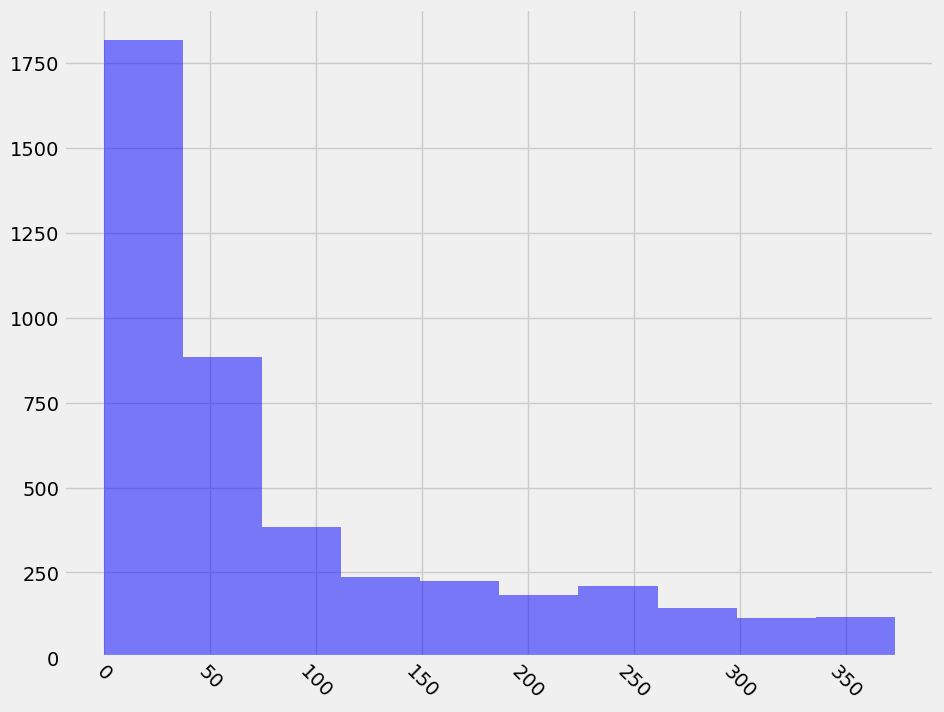

In [50]:
# Visualize recency values
fig = plt.figure(figsize=(10,8))
plt.hist(x='Recency', data=user, facecolor='blue', alpha=0.5,bins=10)
 
# Rotate x-labels
plt.xticks(rotation=-45)

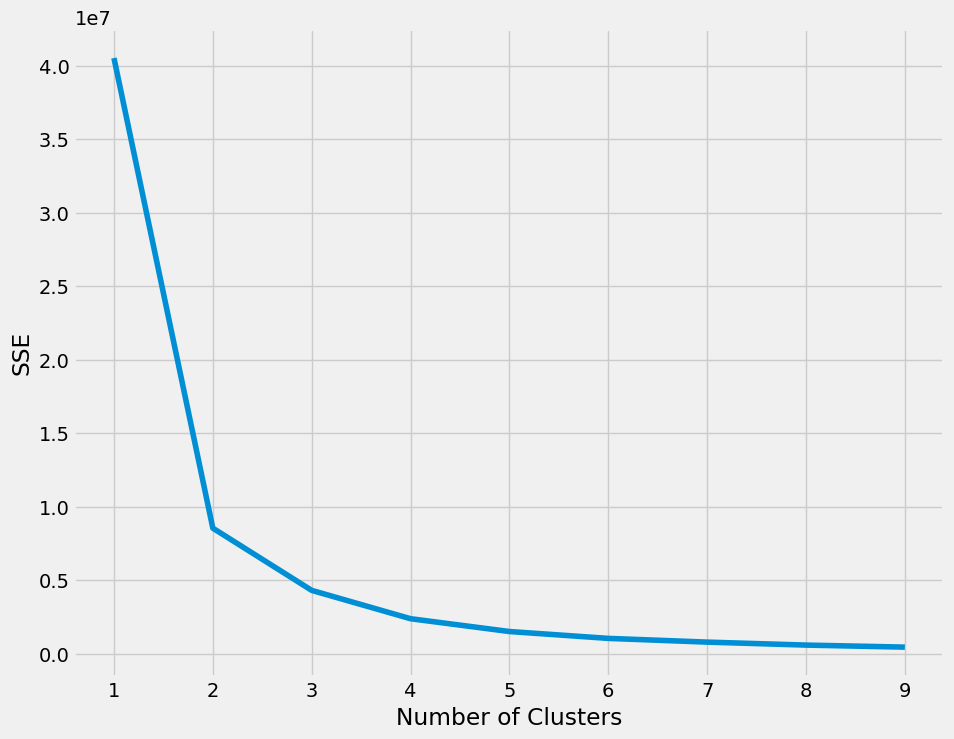

In [51]:
# Using k-means clustering to apply a recency score
sse = {}
recency = user[['Recency']]

# Using Elbow method to find optimal number of clusters. Form clusters with value =1 to 10 and find the corresponding sse
for k in range(1,10):
    kmeans = KMeans(n_clusters= k , max_iter=1000).fit(recency)
    recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_

# ploting the sse
plt.figure(figsize=(10,8))
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [52]:
# Select 5 clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(user[['Recency']])

KMeans(n_clusters=5)

In [53]:
# The Kmeans algorithm assigned a cluster to every user based on recency.
user['RecencyCluster'] = kmeans.predict(user[['Recency']])

# Show userframe with recency cluster
user.head()

,Customer ID,Recency,RecencyCluster
0,13085.0,314,0
1,13078.0,1,3
2,15362.0,83,1
3,18102.0,0,3
4,12682.0,0,3


In [54]:
# Create a new RecencyCluster column to analyze
new_cluster_field_name = 'new_' + 'RecencyCluster'

# Determine the mean recency values based on recency clusters.
user_cluster_mean= user.groupby('RecencyCluster')['Recency'].mean().reset_index()
user_cluster_mean

,RecencyCluster,Recency
0,0,326.983660
1,1,65.641314
2,2,145.188100
3,3,16.231799
4,4,232.582251


Kmeans clustering assigns numerical values to clusters, but not in a particular sequence. The clusters 0 and 1 have mean recencies of 326.9 and 65.65, respectively, while cluster 2 has a mean recency of 145.1 and so on. In order to achieve this, we want cluster 0 to have the highest Mean Recency and cluster 3 to have the lowest Mean Recency.

In [55]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

user = order_cluster('RecencyCluster', 'Recency',user,False)

# Recency values in correct order
user.groupby('RecencyCluster')['Recency'].mean()

RecencyCluster
0    326.983660
1    232.582251
2    145.188100
3     65.641314
4     16.231799
Name: Recency, dtype: float64

In [56]:
user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,306.0,326.983660,31.571357,280.0,301.0,317.5,361.0,373.0
1,462.0,232.582251,25.637231,189.0,211.0,231.0,256.0,279.0
2,521.0,145.188100,25.341042,106.0,122.0,144.0,168.0,188.0
3,1157.0,65.641314,17.163325,41.0,52.0,63.0,78.0,105.0
4,1868.0,16.231799,11.252772,0.0,7.0,15.0,25.0,39.0


##### Significant Analyses Regarding the Recency Cluster
- Customers are concentrated mostly in Cluster 4 and barely any in Cluster 0, which indicates that more customers have recently made purchases. Cluster 4 has a min of 0 and a max of 39. RecencyCluster 4 groups customers who made purchases within the last 1.5 months. Cluster 4 includes the most recent clients.
- Customers in RecencyCluster 0 have not made a purchase in the previous eight months. Inactive customers are covered by Cluster 0.

### Frequency

In [57]:
# count the number of orders by each customer
frequency = df.groupby('Customer ID').InvoiceDate.count().reset_index()
frequency.columns = ['Customer ID','Frequency']

user = pd.merge(user, frequency, on='Customer ID')
user.head()

,Customer ID,Recency,RecencyCluster,Frequency
0,13085.0,314,0,62
1,12636.0,373,0,1
2,12362.0,373,0,1
3,15413.0,326,0,25
4,17592.0,373,0,13


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

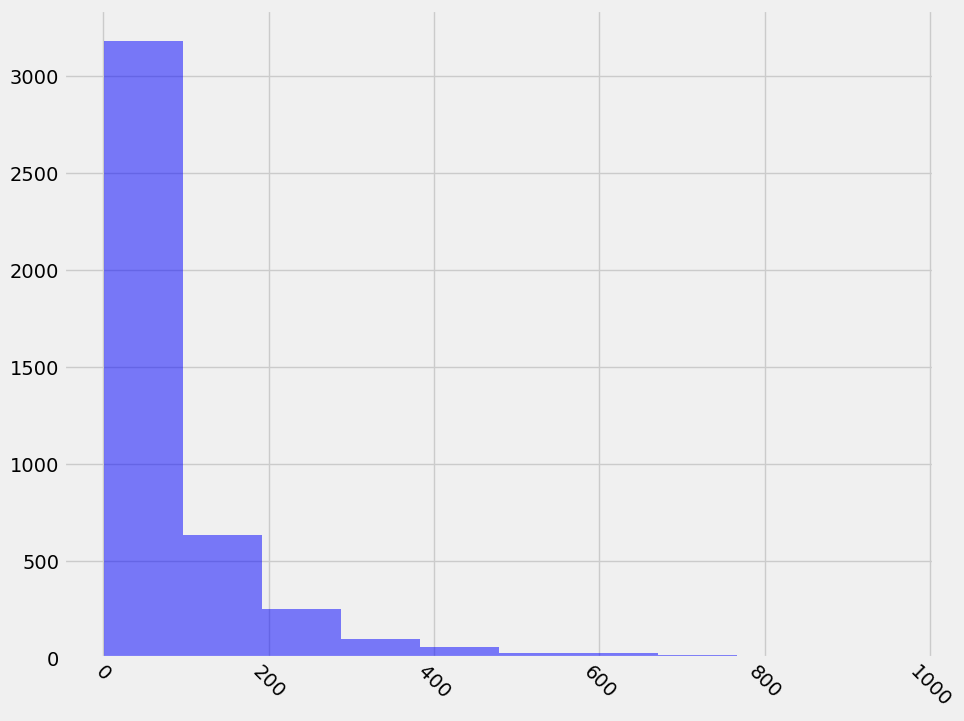

In [58]:
fig = plt.figure(figsize=(10,8))
plt.hist(x='Frequency', data=user[user['Frequency']<1000], facecolor='blue', alpha=0.5)
 
# Rotate x-labels
plt.xticks(rotation=-45)

In [66]:
# Assigning customer order frequency to clusters by K-means
kmeans = KMeans(n_clusters=5)
kmeans.fit(user[['Frequency']])
user['FrequencyCluster'] = kmeans.predict(user[['Frequency']])

#order the frequency cluster
user = order_cluster('FrequencyCluster', 'Frequency',user,True)

#see details of each cluster
user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3406.0,39.011744,30.350394,1.0,14.00,31.0,58.00,119.0
1,751.0,199.741678,65.470644,120.0,145.00,183.0,237.00,375.0
2,138.0,554.108696,161.148057,377.0,428.50,506.0,630.75,1115.0
3,16.0,1705.375000,516.638220,1159.0,1295.25,1544.5,2070.50,2646.0
4,3.0,4771.333333,895.572070,3802.0,4373.00,4944.0,5256.00,5568.0


##### Significant Analyses Regarding the Frequency Cluster
- The cluster 4 has the customers with most number of orders on an average - 4771 orders.

### Revenue

In [60]:
# Calculate revenue for each customer
df['Revenue'] = df['Quantity']*df['Price']
revenue =  df.groupby('Customer ID').Revenue.sum().reset_index()
revenue.columns = ['Customer ID','Revenue']
user = pd.merge(user,revenue,on='Customer ID')
user.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,13085.0,314,0,62,0,2017.20
1,12636.0,373,0,1,0,141.00
2,12362.0,373,0,1,0,130.00
3,15413.0,326,0,25,0,6798.72
4,17592.0,373,0,13,0,148.30


(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

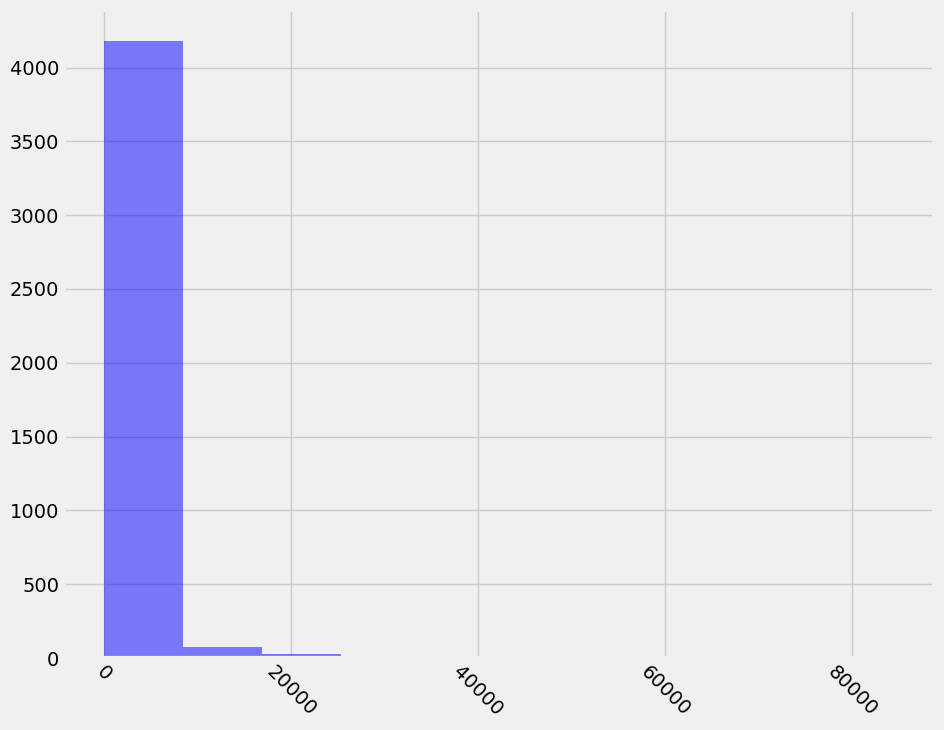

In [61]:
fig = plt.figure(figsize=(10,8))
plt.hist(x='Revenue', data=user[user['Revenue']<100000], facecolor='blue', alpha=0.5)
 
# Rotate x-labels
plt.xticks(rotation=-45)

In [67]:
# Assigning clusters based on revenue by K-means
kmeans = KMeans(n_clusters=5)
kmeans.fit(user[['Revenue']])
user['RevenueCluster'] = kmeans.predict(user[['Revenue']])

user = order_cluster('RevenueCluster','Revenue',user,True)

user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,4171.0,1211.828293,1416.778078,0.00,299.7850,654.090,1563.1650,7832.91
1,123.0,14773.773602,6302.942077,8018.77,9920.7450,12346.620,18401.1350,34095.26
2,15.0,56589.918667,15669.424122,38683.02,44147.7400,52422.300,62808.8350,84541.17
3,3.0,160038.050000,33267.444464,131443.19,141782.2050,152121.220,174335.4800,196549.74
4,2.0,298780.425000,71253.630061,248396.50,273588.4625,298780.425,323972.3875,349164.35


In [63]:
# Creating an overall score based on the metrics above
user['OverallScore'] = user['RecencyCluster'] + user['FrequencyCluster'] + user['RevenueCluster']
user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,327.108197,20.236066,349.388928
1,232.540839,29.324503,552.017331
2,147.144814,39.700587,876.109589
3,67.313297,54.139344,1063.244099
4,19.605596,76.313125,1471.603127
5,14.041899,319.807263,4648.632017
6,10.078125,464.625000,17895.663328
7,5.769231,1203.076923,33289.683846
8,2.625000,2169.750000,97278.736250


##### Key Observation
- Customers with a score of 9 are the most valuable and profitable to us because they are the ones who have made sales, are dependable, and have made recent purchases. Cluster 0 customers are in need of attention because we nearly lost them. The data will be skewed if we don't concentrate on getting them back or take them out of the database and mail letters.
- We divide the customer segment into three levels:
    - 0 to 2 : 'Low Worth'
    - 3 to 4 : 'Mid Worth'
    - 5+ : 'High Worth'

In [68]:
user['Segment'] = 'Low-Worth'
user.loc[user['OverallScore']>2,'Segment'] = 'Mid-Worth' 
user.loc[user['OverallScore']>4,'Segment'] = 'High-Worth'

Text(0, 0.5, 'Revenue')

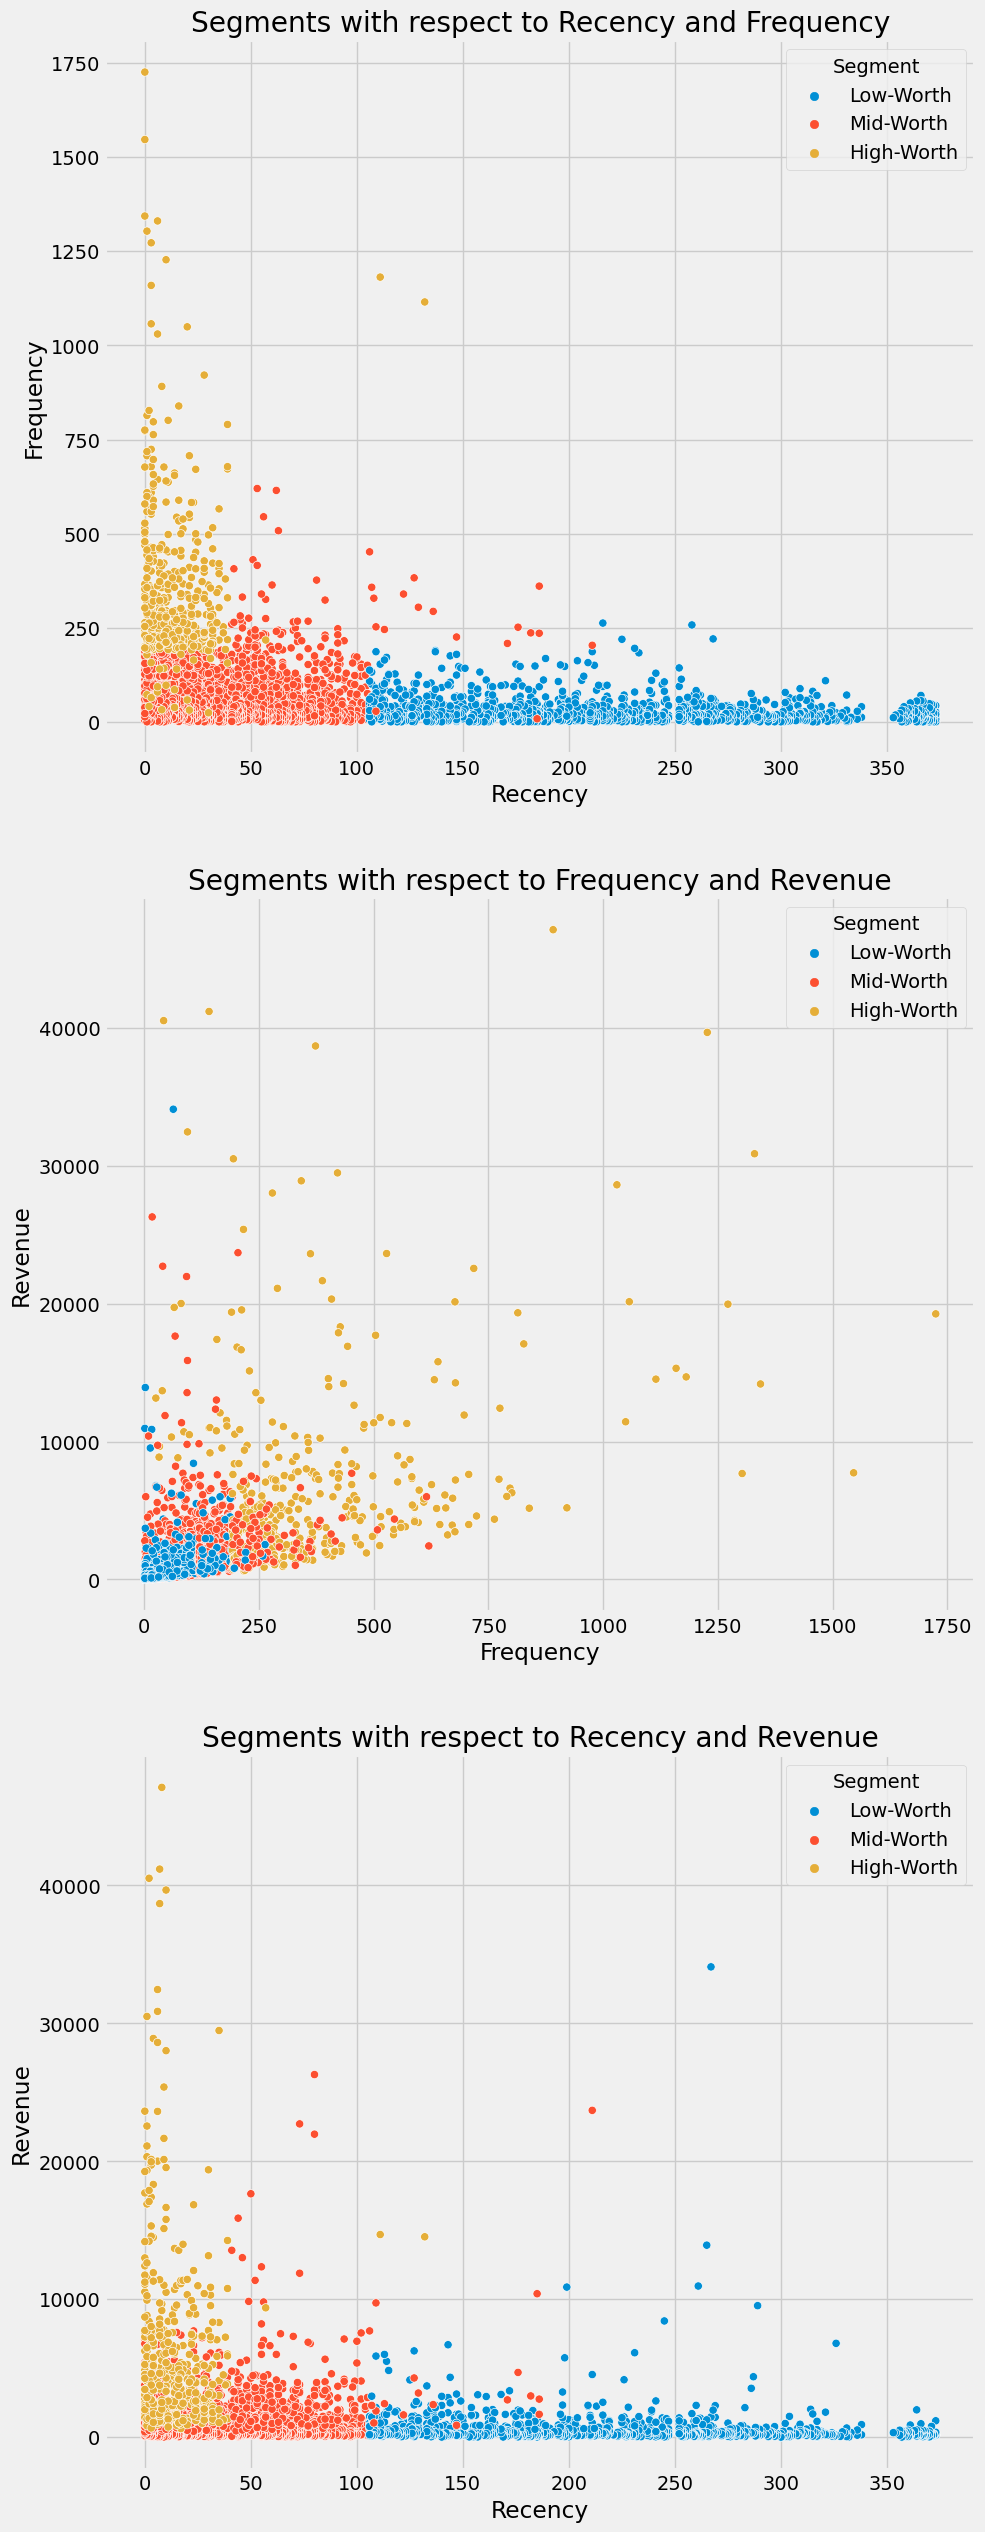

In [69]:
user_plot = user.query("Revenue < 50000 and Frequency < 2000")


fig, ax = plt.subplots(3, 1, figsize=(10,30))
sns.scatterplot(x='Recency', y='Frequency', hue='Segment', data=user_plot, ax=ax[0])
ax[0].set_title('Segments with respect to Recency and Frequency')
ax[0].set_xlabel('Recency')
ax[0].set_ylabel('Frequency')

sns.scatterplot(x='Frequency', y='Revenue', hue='Segment', data=user_plot, ax=ax[1])
ax[1].set_title('Segments with respect to Frequency and Revenue')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Revenue')

sns.scatterplot(x='Recency', y='Revenue', hue='Segment', data=user_plot, ax=ax[2])
ax[2].set_title('Segments with respect to Recency and Revenue')
ax[2].set_xlabel('Recency')
ax[2].set_ylabel('Revenue')

#### Understanding The Segments

As we have already grouped the customers based on the Metrics created for measuring Recency, Frequency and Revenue. Let's Try to understand these segments.

- High-Worth : Based on our segmentation these are the customers who purchased recently. They Generate more revenue to the company and are also frequent buyers. This segment contains our Champions or to say our loyal customers. They are precious for our business and we should keep in touch with them.

- Mid-Worth : This segment has clustered users that have got items somewhat recently are moderately frequent generating moderate revenue. These customers will comprise of new customers as well who have just started buying from us. This segment will also comprise of potential loyalist .

- Low-Worth : This is the most risky segment for the company as it comprises of Lost Customers or Hibernating Customers. The customers and in this group are not active as they didnt buy anything recently, not making much revenue for the company and do not buy frequently.

Recommendations : Target Campaigning Having looked at the three segments in detail. Few recommendations for target Campaigning:

- High-Worth : Take feedbacks from the customers (use to improve business) . As this group is the most profitable for the company asking for their prefernces and personalize offers to keep them happy and satisfied. Focusing to retain them as loyal customers over years is top priority.

- Mid-Worth : As this group comprises of new customers as well , it is important to keep them engaged. Send incentivized offers to get more orders from this group.

- Low-Worth : This group has valuable customers who stopped transacting a long time ago. An attemp to re-engage them by sending crazy lucrative offers to get them back. Make them feel valued by sending personalized recommendations and offers based on their past purchase data

### DBScans